# Jupyter notebook: Latency comparison across scenarios
#
# This notebook loads the four scenario CSVs, preprocesses timestamps/latencies,
# computes summary statistics and draws comparison charts with the three event
# types color-coded: newMachine, machineFailure, storageAlert.


In [1]:
# Section 1: Imports and plotting config
import sys
import json
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Helper for safe pip install in notebook if seaborn/matplotlib not available
try:
    import seaborn as sns  # noqa: F401
except Exception:
    print('Installing seaborn...')
    import subprocess
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'seaborn'])
    import seaborn as sns


In [2]:
# Section 2: Define file paths & scenario mapping and load CSVs
from pprint import pprint

base = Path('.')  # workspace root
results_dir = base / 'src' / 'dockerProject' / 'results'

# Requested order: 5m_1k, 5m_2k, 5m_3k, 5m_4k, 3m_1k, 3m_2k
files_order = [
    ('results_scenario_5m_1k_run1.csv', '5m_1k'),
    ('results_scenario_5m_2k_run1.csv', '5m_2k'),
    ('results_scenario_5m_3k_run1.csv', '5m_3k'),
    ('results_scenario_5m_4k_run1.csv', '5m_4k'),
    ('results_scenario_3m_1k_run1.csv', '3m_1k'),
    ('results_scenario_3m_2k_run1.csv', '3m_2k'),
]

# Read CSVs
dfs = {}
for fname, label in files_order:
    path = results_dir / fname
    if not path.exists():
        print(f"WARNING: file not found: {path}")
        dfs[label] = pd.DataFrame()
        continue
    df = pd.read_csv(path, dtype={"metadata": str})
    df['__source_filename'] = fname
    df['scenario'] = label
    dfs[label] = df

print('Loaded scenarios:')
for k, df in dfs.items():
    print(k, 'rows =', len(df))


Loaded scenarios:
5m_1k rows = 100
5m_2k rows = 200
5m_3k rows = 100
5m_4k rows = 159
3m_1k rows = 100
3m_2k rows = 100


In [3]:
# Section 3: Preprocess timestamps, latencies and parse metadata
import math

# helper to coerce numeric, keep NaN when missing
def to_int_safe(x):
    try:
        if pd.isna(x):
            return np.nan
        return int(x)
    except Exception:
        try:
            return int(float(x))
        except Exception:
            return np.nan

processed = []
for label, df in dfs.items():
    if df.empty:
        continue
    d = df.copy()
    # numeric coercion
    for col in ['trigger_ts', 'reaction_ts', 'solved_ts', 'resolution_time_ms', 'total_response_time_ms']:
        if col in d.columns:
            d[col] = pd.to_numeric(d[col], errors='coerce')
        else:
            d[col] = np.nan

    # timestamps -> datetimes (ms)
    d['trigger_dt'] = pd.to_datetime(d['trigger_ts'], unit='ms', errors='coerce')
    d['reaction_dt'] = pd.to_datetime(d['reaction_ts'], unit='ms', errors='coerce')
    d['solved_dt'] = pd.to_datetime(d['solved_ts'], unit='ms', errors='coerce')

    # derived delays
    d['reaction_delay_ms'] = d['reaction_ts'] - d['trigger_ts']
    d['solved_delay_ms'] = d['solved_ts'] - d['trigger_ts']

    # parse metadata JSON safely
    def parse_meta(s):
        if pd.isna(s):
            return {}
        try:
            return json.loads(s)
        except Exception:
            # sometimes single quotes or escaping; try replace
            try:
                return json.loads(s.replace("'", '"'))
            except Exception:
                return {}

    meta_parsed = d['metadata'].fillna('{}').map(parse_meta)
    # expand a few common fields
    d['meta_first_state'] = meta_parsed.map(lambda m: m.get('first_state') if isinstance(m, dict) else None)
    d['meta_swap_target_machine'] = meta_parsed.map(lambda m: m.get('swap_target_machine') if isinstance(m, dict) else None)
    d['meta_problemCategory'] = meta_parsed.map(lambda m: m.get('problemCategory') if isinstance(m, dict) else None)

    # ensure event_type is str
    d['event_type'] = d['event_type'].astype(str)
    processed.append(d)

# concatenate
if processed:
    master = pd.concat(processed, ignore_index=True, sort=False)
else:
    master = pd.DataFrame()

print('Master rows:', len(master))

# quick sanity: unique event types
print('Event types:', master['event_type'].unique() if 'event_type' in master.columns else [])


Master rows: 759
Event types: ['newMachine' 'machineFailure' 'storageAlert']


In [4]:
# Section 4: Aggregates and comparison table (focus on MEAN, include seconds)
# Compute summary statistics per scenario and event_type
if master.empty:
    print('No data to summarize')
else:
    agg = master.groupby(['scenario','event_type']).agg(
        count=('event_id','count'),
        mean_total_response_ms=('total_response_time_ms','mean'),
        median_total_response_ms=('total_response_time_ms','median'),
        std_total_response_ms=('total_response_time_ms','std'),
        q25_total_response_ms=('total_response_time_ms', lambda x: np.nanpercentile(x.dropna(), 25) if len(x.dropna())>0 else np.nan),
        q75_total_response_ms=('total_response_time_ms', lambda x: np.nanpercentile(x.dropna(), 75) if len(x.dropna())>0 else np.nan),
        mean_resolution_ms=('resolution_time_ms','mean'),
        median_resolution_ms=('resolution_time_ms','median')
    ).reset_index()

    # Add mean values in seconds (divide ms by 1000)
    agg['mean_total_response_s'] = agg['mean_total_response_ms'] / 1000.0
    agg['mean_resolution_s'] = agg['mean_resolution_ms'] / 1000.0

    # pivoted comparison table (MEAN in seconds)
    pivot_mean_s = agg.pivot(index='event_type', columns='scenario', values='mean_total_response_s')
    # reorder columns to the requested scenario order
    pivot_mean_s = pivot_mean_s[['5m_1k','5m_2k','5m_3k','5m_4k','3m_1k','3m_2k']]

    print('\nMean total_response_time (seconds) by event_type and scenario (requested order):')
    display(pivot_mean_s)

    # Save summary CSVs (agg in ms + mean table in seconds)
    out_dir = Path('analysis_outputs')
    out_dir.mkdir(exist_ok=True)
    agg.to_csv(out_dir / 'summary_by_scenario_eventtype.csv', index=False)
    pivot_mean_s.to_csv(out_dir / 'mean_table_seconds.csv')
    print('\nSaved summaries to', out_dir, ' (including mean_table_seconds.csv)')



Mean total_response_time (seconds) by event_type and scenario (requested order):


scenario,5m_1k,5m_2k,5m_3k,5m_4k,3m_1k,3m_2k
event_type,,,,,,
machineFailure,981.465000,1304.184808,814.026926,887.375600,804.188722,2511.026509
newMachine,107.783769,117.922852,85.333313,124.857359,107.898509,119.291105
storageAlert,138.929000,219.442808,172.017833,158.040529,175.254333,262.045400



Saved summaries to analysis_outputs  (including mean_table_seconds.csv)


/var/folders/kf/fqsk3qbn3h9ccbj4wkfz9g200000gn/T/ipykernel_36181/4287726974.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/kf/fqsk3qbn3h9ccbj4wkfz9g200000gn/T/ipykernel_36181/4287726974.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/kf/fqsk3qbn3h9ccbj4wkfz9g200000gn/T/ipykernel_36181/4287726974.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/kf/fqsk3qbn3h9ccbj4wkfz9g200000gn/T/ipykernel_36181/4287726974.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated a

Saved boxplots to analysis_outputs/boxplots_total_response_time_ms.png
Saved percentage grouped bar chart to analysis_outputs/percentage_by_eventtype.png
Saved counts grouped bar chart to analysis_outputs/counts_by_eventtype.png


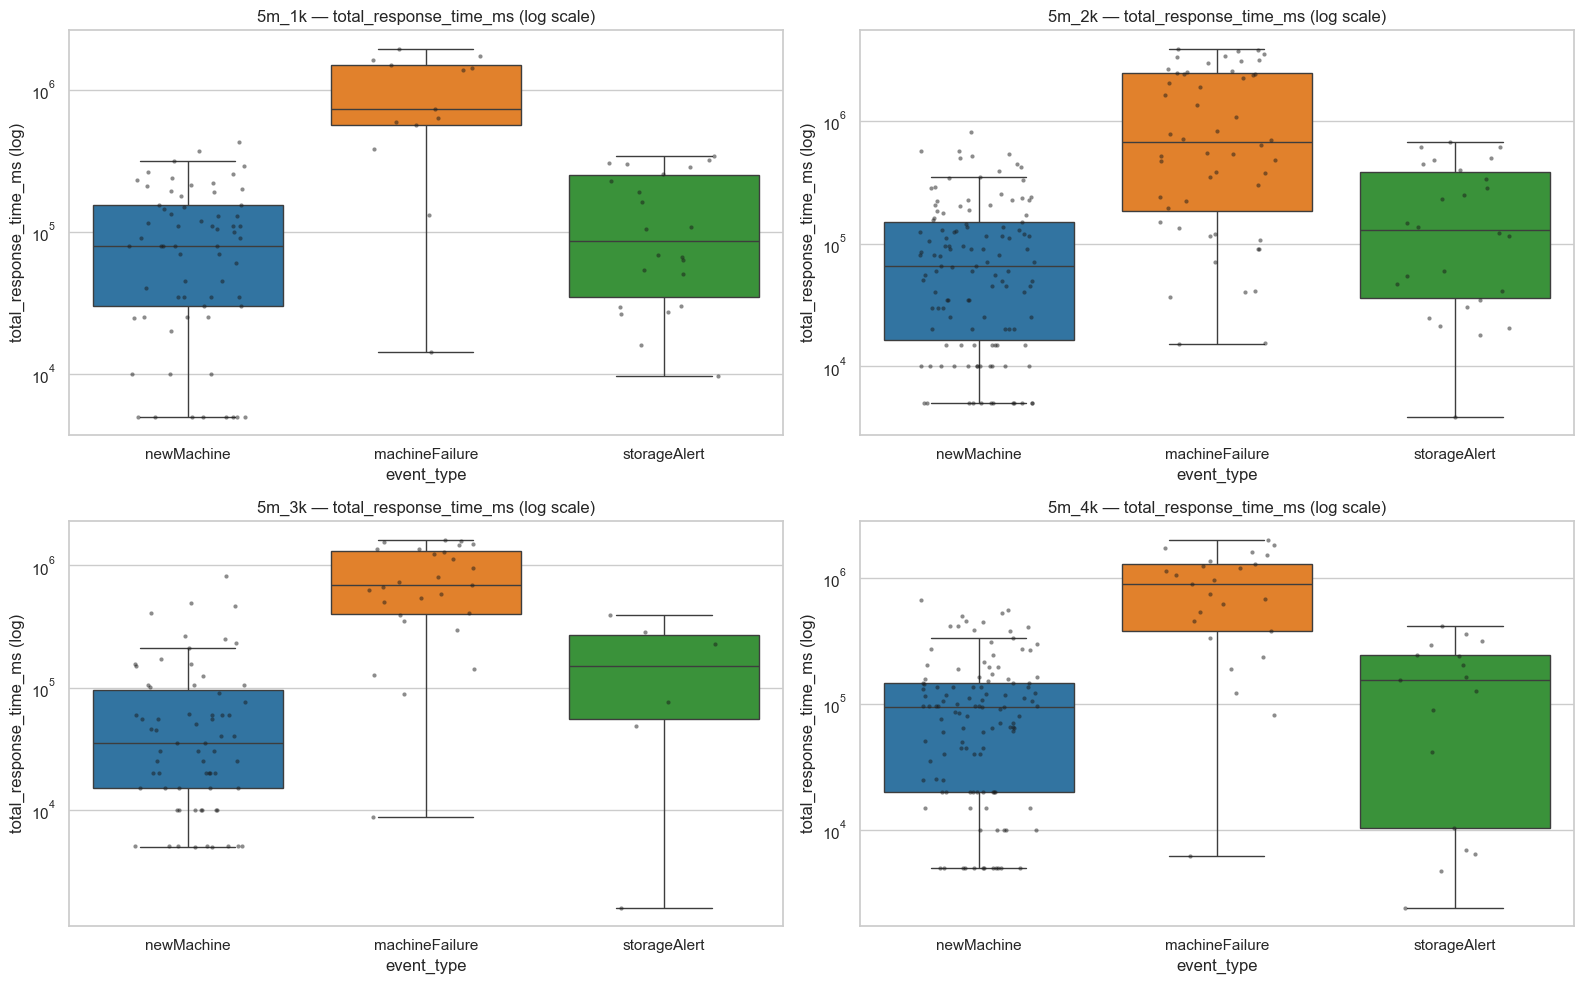

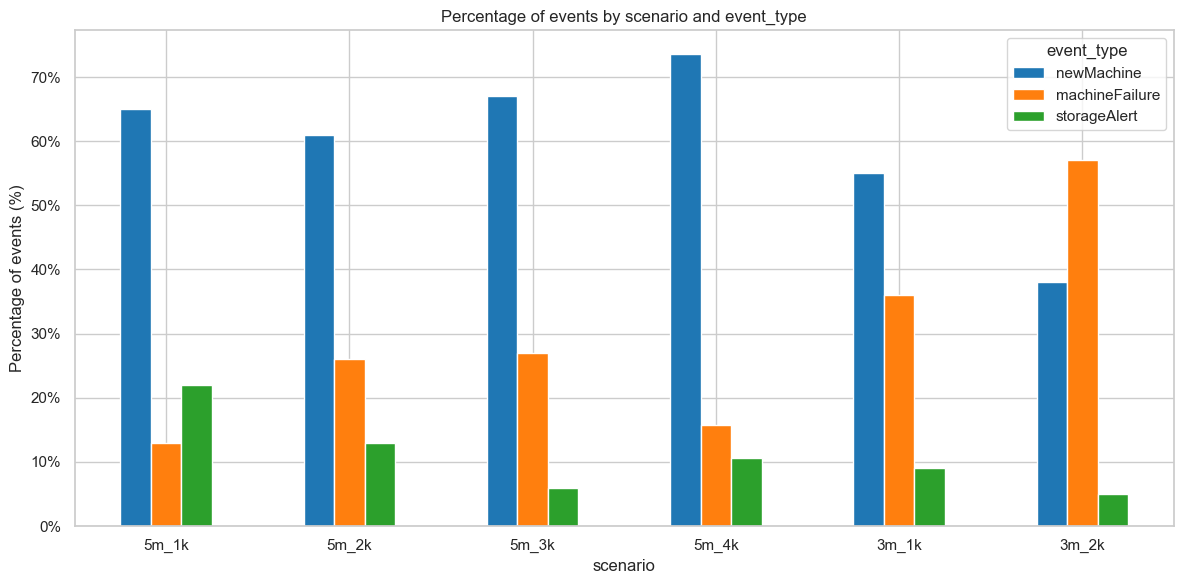

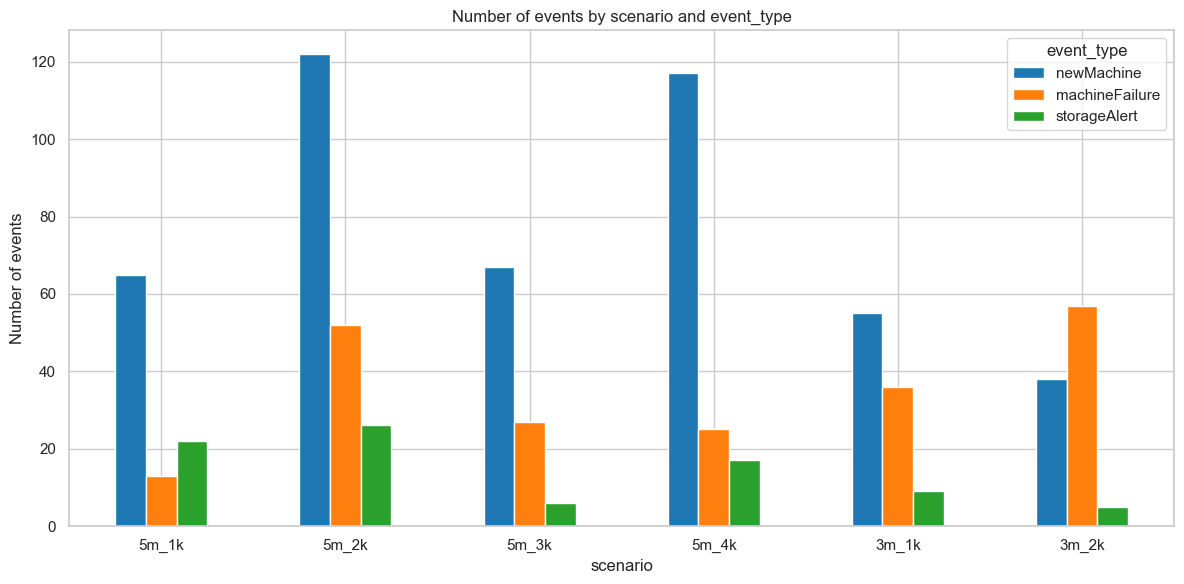

In [9]:
# Section 5: Plots — boxplots (per-scenario) and a grouped bar chart showing PERCENTAGE of events per event_type
import matplotlib.ticker as ticker

if master.empty:
    print('No data to plot')
else:
    event_order = ['newMachine', 'machineFailure', 'storageAlert']
    # consistent color mapping
    color_map = {
        'newMachine': '#1f77b4',
        'machineFailure': '#ff7f0e',
        'storageAlert': '#2ca02c'
    }

    scenarios = ['5m_1k','5m_2k','5m_3k','5m_4k','3m_1k','3m_2k']

    # --- Per-scenario boxplots (log scale) ---
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    axes = axes.flatten()
    for ax, scen in zip(axes, scenarios):
        sub = master[master['scenario'] == scen]
        if sub.empty:
            ax.text(0.5, 0.5, f'No data for {scen}', ha='center')
            ax.set_xticks([])
            continue
        # boxplot — total_response_time_ms by event_type
        sns.boxplot(
            data=sub,
            x='event_type', y='total_response_time_ms',
            order=event_order,
            palette=[color_map.get(e, '#333333') for e in event_order],
            ax=ax,
            showfliers=False
        )
        # overlay some points (jittered)
        sns.stripplot(
            data=sub, x='event_type', y='total_response_time_ms',
            order=event_order, color='k', size=3, jitter=0.25, alpha=0.5, ax=ax
        )
        ax.set_yscale('log')
        ax.set_title(f'{scen} — total_response_time_ms (log scale)')
        ax.set_xlabel('event_type')
        ax.set_ylabel('total_response_time_ms (log)')

    plt.tight_layout()
    out_dir = Path('analysis_outputs')
    out_dir.mkdir(exist_ok=True)
    plt.savefig(out_dir / 'boxplots_total_response_time_ms.png', dpi=150)
    print('Saved boxplots to', out_dir / 'boxplots_total_response_time_ms.png')

    # --- Grouped bar chart: percentage of each event type per scenario ---
    # counts per scenario x event_type
    counts = master.groupby(['scenario','event_type']).size().unstack(fill_value=0).reindex(scenarios).fillna(0)
    # ensure column order
    counts = counts[event_order]

    # save raw counts
    counts.to_csv(out_dir / 'counts_by_scenario_eventtype.csv')

    # compute percentage per scenario (row-wise)
    totals = counts.sum(axis=1).replace(0, np.nan)
    percent = counts.div(totals, axis=0).fillna(0) * 100.0
    percent.to_csv(out_dir / 'percent_by_scenario_eventtype.csv')

    # plot grouped bars: x=scenario, bars=event types (percentage)
    ax = percent.plot(kind='bar', figsize=(12,6), color=[color_map[e] for e in event_order])
    ax.set_ylabel('Percentage of events (%)')
    ax.set_title('Percentage of events by scenario and event_type')
    ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=100))
    plt.xticks(rotation=0)
    plt.legend(title='event_type')
    plt.tight_layout()
    plt.savefig(out_dir / 'percentage_by_eventtype.png', dpi=150)
    print('Saved percentage grouped bar chart to', out_dir / 'percentage_by_eventtype.png')

    # Also provide a raw-number grouped bar plot (optional) for comparison
    ax2 = counts.plot(kind='bar', figsize=(12,6), color=[color_map[e] for e in event_order])
    ax2.set_ylabel('Number of events')
    ax2.set_title('Number of events by scenario and event_type')
    plt.xticks(rotation=0)
    plt.legend(title='event_type')
    plt.tight_layout()
    plt.savefig(out_dir / 'counts_by_eventtype.png', dpi=150)
    print('Saved counts grouped bar chart to', out_dir / 'counts_by_eventtype.png')


# Section 6: Notes & how to run

1. Open this notebook in Jupyter/VS Code and run all cells in order.
2. The notebook expects the CSVs in `src/dockerProject/results/` (relative to repo root).
3. Output files (summaries + PNGs) are saved to `analysis_outputs/`.

If seaborn is not available, the notebook will try to install it automatically. If you prefer to install packages manually, run:

```bash
python3 -m pip install seaborn matplotlib pandas
```

That's it — run the cells and you should see the 2x2 boxplots and grouped bar chart comparing latencies across scenarios, with event types color-coded.
